**Steps for Fine-tuning the Model for Multiomics Integration:**

1.  **Prepare Your Environment:** Ensure you have the necessary Python libraries installed (as indicated in the original script).
2.  **Download Datasets and Pre-trained Model:** Obtain the gene and protein expression data files for training and testing, as well as the pre-trained model files.
3.  **Organize File Paths:** Make sure the paths to your data files and the pre-trained model are correctly specified.
4.  **Execute the Python Script:** Run the Python script from your terminal, providing the required parameters to control the fine-tuning process.
5.  **Monitor Training (if applicable):** If you are training (`--do_train`), observe the output in your terminal to track the progress (loss, learning rate, etc.).
6.  **Locate Output Files:** After the script finishes, the fine-tuned model, generated feature files and predicted results will be saved in the directory specified by the `--save_dir` parameter (Please download our dataset, fine-tuned models, generated feature files from https://drive.google.com/drive/folders/1EUjRZqNOFYNwBpGZoAGeyccqk3couReK?usp=drive_link).

**Python Command to Run Fine-tuning:**

```bash
python finetune.py --mode train --species human --rna_file /home/jiboya/captain/data/rna.h5ad --adt_file /home/jiboya/captain/data/adt.h5ad --save_dir /home/jiboya/captain/results --load_model /home/jiboya/captain/model --seed 0 --mask_ratio 0.4 --epochs 100 --batch_size 15 --lr 1e-3
```
**Python Command to Generate Joint Embedding:**
```bash
python finetune.py --mode eval --species human --rna_file /home/jiboya/captain/data/rna.h5ad --adt_file /home/jiboya/captain/data/adt.h5ad --save_dir /home/jiboya/captain/results --load_model /home/jiboya/captain/model
```

**Explanation of the Command:**
* `--mode`: Sets the script to training or evaluation mode.
* `--species`: Specifies the species of the dataset. Use human or mouse. Default is human.
* `--rna_file`: Required. Provides the path to the RNA data file (e.g., rna.h5ad).
* `--adt_file`: Required. Provides the path to the ADT (protein expression) data file (e.g., adt.h5ad).
* `--save_dir`: Sets the directory where the training results (model checkpoints, logs, etc.) will be saved. Default is /home/jiboya/captain/results.
* `--load_model`: Optional. Specifies the path to a directory containing a pre-trained model to load for further training or fine-tuning.
* `--seed`: Sets the random seed for reproducibility.
* `--mask_ratio`: Defines the ratio of input data to be masked during training (a common technique in self-supervised learning).
* `--epochs`: Sets the number of times the entire training dataset will be passed through the model during training.
* `--batch_size`: Determines the number of data samples processed together in one batch during training.
* `--lr`: Sets the learning rate, controlling the step size during the optimization process.

Remember to adjust the file paths according to the actual location of your data and pre-trained model. You can also modify other parameters as needed based on your specific requirements.



In [5]:
import functools
import json
import logging
import os
from pathlib import Path
import random
import subprocess
from typing import Dict, List, Mapping, Optional, Tuple, Union
import scanpy as sc
import numpy as np
import torch
import pandas as pd
from anndata import AnnData
import scib
from matplotlib import pyplot as plt
from matplotlib import axes
# Wrapper for all scib metrics, we leave out some metrics like hvg_score, cell_cyvle,
# trajectory_conservation, because we only evaluate the latent embeddings here and
# these metrics are evaluating the reconstructed gene expressions or pseudotimes.
def eval_scib_metrics(
    adata: AnnData,
    batch_key: str = "sample_id",
    label_key: str = "full_clustering",
    notes: Optional[str] = None,
) -> Dict:
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=label_key,
        embed="X_captain",
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )

    if notes is not None:
        print(f"{notes}")

    print(f"{results}")

    result_dict = results[0].to_dict()
    print(
        "Biological Conservation Metrics: \n"
        f"ASW (cell-type): {result_dict['ASW_label']:.4f}, graph cLISI: {result_dict['cLISI']:.4f}, "
        f"isolated label silhouette: {result_dict['isolated_label_silhouette']:.4f}, \n"
        "Batch Effect Removal Metrics: \n"
        f"PCR_batch: {result_dict['PCR_batch']:.4f}, ASW (batch): {result_dict['ASW_label/batch']:.4f}, "
        f"graph connectivity: {result_dict['graph_conn']:.4f}, graph iLISI: {result_dict['iLISI']:.4f}"
    )

    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )

    # remove nan value in result_dict
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}

    return result_dict

import pickle as pkl
import numpy as np
with open('/home/jiboya/Captain/multiomics/dataset2/captain/adt_embeddings.pickle', 'rb') as fp:
    adt_embeddings=pkl.load(fp)
adt_embeddings=np.array(adt_embeddings)

adata=sc.read_h5ad("/home/jiboya/Captain/multiomics/dataset2/adata.h5ad")
adata.obsm["X_captain"] = adt_embeddings

In [6]:
adata.write_h5ad("/home/jiboya/Captain/multiomics/dataset2/captain/captainresult.h5ad")

In [2]:
result_dict=eval_scib_metrics(adata)
result_dict

Recompute neighbors on rep X_captain instead of None
Cluster for cluster_0.2 with leiden


/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Graph connectivity...
                                  0
NMI_cluster/label          0.742309
ARI_cluster/label          0.691314
ASW_label                  0.538850
ASW_label/batch                 NaN
PCR_batch                  0.665162
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.888464
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.5388, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.6652, ASW (batch): nan, graph connectivity: 0.8885, graph iLISI: nan


/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future 

{'NMI_cluster/label': 0.7423086865923619,
 'ARI_cluster/label': 0.691313881075278,
 'ASW_label': 0.5388496699577562,
 'PCR_batch': 0.6651620183506983,
 'graph_conn': 0.8884644520418679,
 'avg_bio': 0.657490745875132}

In [3]:
import omicverse as ov
import scanpy as sc
ov.plot_set()

/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_data.py:268: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/jiboya/anaconda3/envs/omicverse/lib/python3.10/site-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/lat


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/
Dependency error: The 'bioservices' distribution was not found and is required by the application


computing neighbors
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


Text(0.5, 1.0, 'Captain, AvgBIO=0.657')

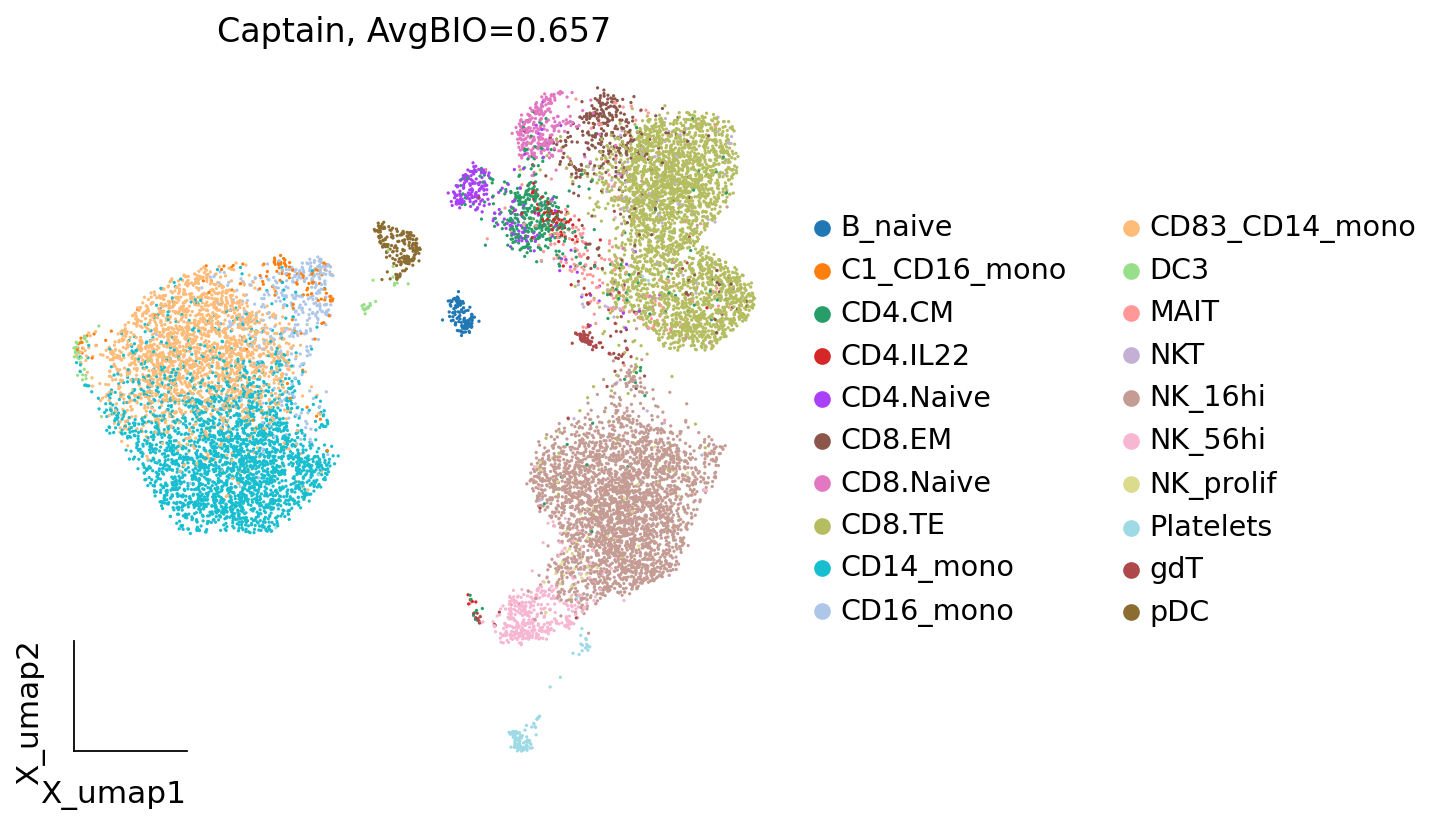

In [4]:
import pickle as pkl
import numpy as np

adt_embeddings=np.array(adt_embeddings)
adt_embeddings = sc.AnnData(adt_embeddings)
adt_embeddings.obs=adata.obs

sc.pp.neighbors(adt_embeddings)
sc.tl.umap(adt_embeddings)


import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (6,6))
ov.pl.embedding(adt_embeddings,
                basis='X_umap',
               color='full_clustering',
               frameon='small',
               show=False,

               ax=ax,)
plt.title('Captain, AvgBIO=0.657',fontsize=15)